In [1]:
%cd ../..
# %pip install .
import time
from os import environ
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# point1 = OrientedPoint ahead of ego by Range(0, 40)
# Car at (point1 offset by Range(-1, 1) @ 0),
#     facing Range(-15, 15) deg relative to roadDirection



/home/yongming/workspace/research/apperception_new_local/apperception


In [2]:
environ['AP_PORT'] = str(input('port')) # README command uses port=25432

port25432


In [3]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os
import random

experiment_data_dir =  "data/nuscenes/experiment_data"
# experiment_data_dir = '/work/apperception/data/nuScenes/full-dataset-v1.0/Trainval/experiment_data'
def show_images(images, sample=None):
    if sample is not None:
        images = [i for i in images]
        random.shuffle(images)
        images = images[:sample]
    
    plt.figure(figsize=(60,30))
    columns = 3

    for i, image in enumerate(images):
        print("image", image)
        img = mpimg.imread(os.path.join(experiment_data_dir, image))
        print("loaded")
        plt.subplot(len(images) // columns + 1, columns, i + 1)
        plt.imshow(img)

In [4]:
#### First part of the query ####
from apperception.world import empty_world
# directly ingest the mini dataset and boston roadnetwork if needed
# from apperception.database import database
# database.reset()
# from benchmarks.ingest_scenic_data import ingest_data
# ingest_data()


name = 'ScenicWorld' # world name
world = empty_world(name=name)

### Query ###
from apperception.utils import F
# world = world.predicate(lambda obj: obj.object_type == 'vehicle')
def pred(obj1, cam):
    return (
        F.like(obj1.object_type, 'vehicle%') and
        F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp), cam.timestamp) > -15 and
        F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp), cam.timestamp) < 15 and
        F.view_angle(obj1, cam.ego, cam.timestamp) < 67.5 and
        F.distance(cam.ego, obj1, cam.timestamp) < 40 and
        F.facing_relative(obj1, F.road_direction(obj1.traj, cam.timestamp, cam.ego), cam.timestamp) > -15 and 
        F.facing_relative(obj1, F.road_direction(obj1.traj, cam.timestamp, cam.ego), cam.timestamp) < 15 and
        F.ahead(obj1, cam.ego, cam.timestamp)
    )
world = world.filter("lambda obj1, cam: " +
        "F.like(obj1.object_type, 'vehicle%') and " +
        "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.view_angle(obj1, cam.ego, cam.timestamp) < 67.5 and " +
        "F.distance(cam.ego, obj1, cam.timestamp) < 40 and " +
        "F.angle_between(F.facing_relative(obj1, F.road_direction(obj1.traj, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.ahead(obj1, cam.ego, cam.timestamp)")

start = time.time()
# keys = world.get_traj_key()
id_time_camId_filename_1 = world.get_id_time_camId_filename(num_joined_tables=1)

end = time.time()
print(format(end-start))

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT table_0.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as table_0
        
        JOIN Cameras USING (cameraId)
        WHERE ((table_0.objectType LIKE 'vehicle%') AND angleBetween(facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp), (-15), 15) AND (viewAngle(table_0.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<67.5) AND (distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp)<40) AND angleBetween(facingRelative(table_0.itemHeadings, roadDirection(table_0.trajCentroids, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp), (-15), 15) AND ahead(table_0.trajCentroids, Cameras.egoTranslation, Cameras.egoHeading, Cameras.timestamp))
        
done execute node
Result length: 775
28.249786853790

In [5]:
resultImages_1 = dict() # maping from image -> (itemId, timestamp, camId) that it was found at
for result in id_time_camId_filename_1:
    itemId, timestamp, camId, filename = result
    filename = filename.split("/")[-1] # use split so that prefix path is not included in filename
    resultImages_1[filename] = (itemId, timestamp, camId)
    if filename == 'n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg':
        print("exists")

exists
exists


In [ ]:
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# oppositeCar = Car offset by (Range(-10, -1), Range(0, 50)),
#     facing Range(140, 180) deg relative to ego.heading

# point2 = OrientedPoint ahead of oppositeCar by Range(0, 40)
# Car at (point2 offset by Range(-1, 1) @ 0),
#     facing Range(-15, 15) deg relative to roadDirection

In [6]:
### Second part of the query ###
from apperception.world import empty_world

name = 'ScenicWorld' # world name
world = empty_world(name=name)

### Query ###
from apperception.utils import F

world = world.filter("lambda opposite_car, car2, cam: " +
        "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.convert_camera(opposite_car, cam.ego, cam.timestamp) > [-10, 0] and " +
        "F.convert_camera(opposite_car, cam.ego, cam.timestamp) < [-1, 50] and " +
        "F.angle_between(F.facing_relative(opposite_car, cam.ego, cam.timestamp), 140, 180) and " +
        "F.like(car2.object_type, 'vehicle%') and F.like(opposite_car.object_type, 'vehicle%') and " +
        "opposite_car.itemId != car2.itemId and " +
        "F.distance(opposite_car, car2, cam.timestamp) < 40 and " +
        "F.angle_between(F.facing_relative(car2, F.road_direction(car2.traj, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.ahead(car2, opposite_car, cam.timestamp)")

start = time.time()
# keys = world.get_traj_key()
id_time_camId_filename_2 = world.get_id_time_camId_filename(num_joined_tables=2)
# print([e[4] for e in id_time_camId_filename_2])
end = time.time()
print(format(end-start))

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT table_0.itemId,table_1.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as table_0
        JOIN (SELECT * FROM item_general_trajectory) as table_1 USING (cameraId)
        JOIN Cameras USING (cameraId)
        WHERE (angleBetween(facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp), (-15), 15) AND (ConvertCamera(table_0.trajCentroids, Cameras.egoTranslation, Cameras.egoHeading, Cameras.timestamp)>ARRAY[(-10),0]) AND (ConvertCamera(table_0.trajCentroids, Cameras.egoTranslation, Cameras.egoHeading, Cameras.timestamp)<ARRAY[(-1),50]) AND angleBetween(facingRelative(table_0.itemHeadings, Cameras.egoHeading, Cameras.timestamp), 140, 180) AND (table_1.objectType LIKE 'vehicle%') AND (table_0.objectType LIKE 'vehicle%') AND (table_0.itemId<>table_1.itemId) 

In [7]:
resultImages_2 = dict() # maping from image -> (itemId, timestamp, camId) that it was found at
for result in id_time_camId_filename_2:
    itemId_1, itemId_2, timestamp, camId, filename = result
    filename = filename.split("/")[-1] # use split so that prefix path is not included in filename
    resultImages_2[filename] = [(itemId_1, itemId_2, timestamp, camId)] if filename not in resultImages_2 else resultImages_2[filename]+[(itemId_1, itemId_2, timestamp, camId)]
print(resultImages_2['n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg'])

[('80822ed2772143f6adce345c6ae4565e', '6a81ab78eee3477e8509569a5d0a2217', datetime.datetime(2018, 7, 26, 9, 18, 40, 162404, tzinfo=datetime.timezone.utc), 'scene-0207'), ('679391fb87db41cc97b4b6233c8795f5', 'fd2437defb374b4a96cbd6cf3d79be26', datetime.datetime(2018, 7, 26, 9, 18, 40, 162404, tzinfo=datetime.timezone.utc), 'scene-0207')]


In [ ]:
show_images(list(resultImages_2.keys()), sample=10)

image n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg
loaded
image n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920662404.jpg
loaded


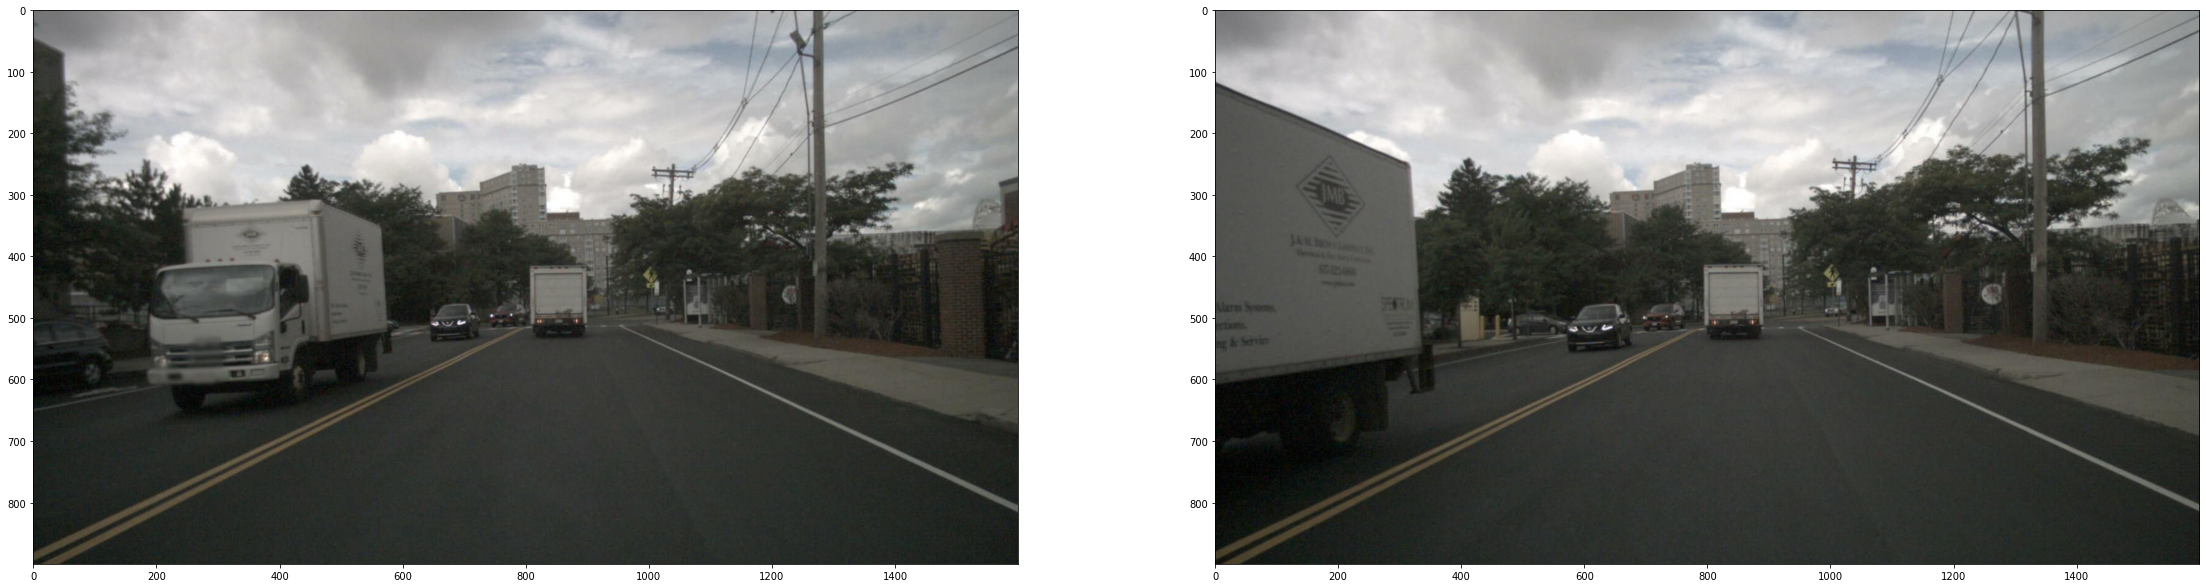

In [5]:
expected_imgs = ["n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg", "n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920662404.jpg"]
show_images(expected_imgs)

In [6]:
### Getting info about the expected images
from apperception.database import database
for img in expected_imgs:
    prefix = "samples/CAM_FRONT/"
    query = f"""SELECT 
    \'Camera: \', Cameras.egoHeading, ST_X(Cameras.egoTranslation), ST_Y(Cameras.egoTranslation), ST_Z(Cameras.egoTranslation),
    \'Cars: \', table_0.itemId, getX(table_0.trajCentroids, Cameras.timestamp), getY(table_0.trajCentroids, Cameras.timestamp), 
    ST_Z(valueAtTimestamp(table_0.trajCentroids, Cameras.timestamp)), 
    \'Distance: \', distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp),
    \'CarHeading:\', valueAtTimestamp(table_0.itemHeadings, Cameras.timestamp),
    \'RoadDirection for car:\', roadDirection(table_0.trajCentroids, Cameras.timestamp, valueAtTimestamp(table_0.itemHeadings, Cameras.timestamp)::real),
    \'Ahead: \', ahead(table_0.trajCentroids, Cameras.egoTranslation, Cameras.egoHeading, Cameras.timestamp),
    \'Angle to ego: \', facingRelative(table_0.itemHeadings, Cameras.egoHeading, Cameras.timestamp) 
    FROM Item_General_Trajectory AS table_0, Cameras
                WHERE Cameras.filename = \'{prefix + img}\' AND table_0.cameraId = Cameras.cameraId 
                AND table_0.objectType LIKE 'vehicle%' 
                AND getX(table_0.trajCentroids, Cameras.timestamp) IS NOT NULL
"""
    database.cursor.execute(query)
    result = database.cursor.fetchall()
    print(result)

[('Camera: ', 59.95824, 1927.3625156512157, 1053.3215015295318, 0.0, 'Cars: ', '00ebba0d172744139abca3a6339a4617', 1934.9782725527593, 1066.2899041172232, 0.126, 'Distance: ', 15.039255927732874, 'CarHeading:', -121.74400000080458, 'RoadDirection for car:', -121.744, 'Ahead: ', False, 'Angle to ego: ', 178.298), ('Camera: ', 59.95824, 1927.3625156512157, 1053.3215015295318, 0.0, 'Cars: ', '7b56d313d22b44e8ae6160957021f2be', 1880.739635790291, 1059.6438589138302, 0.039000000000000035, 'Distance: ', 47.049602861459036, 'CarHeading:', 147.27599999956564, 'RoadDirection for car:', 147.276, 'Ahead: ', False, 'Angle to ego: ', 87.3178), ('Camera: ', 59.95824, 1927.3625156512157, 1053.3215015295318, 0.0, 'Cars: ', 'b7eb5ea2137c4575bbd62375e3cc3063', 1945.8435469754854, 1035.5504545820713, 0.01100000000000012, 'Distance: ', 25.63900599511381, 'CarHeading:', -122.7870000002036, 'RoadDirection for car:', -122.787, 'Ahead: ', False, 'Angle to ego: ', 177.255), ('Camera: ', 59.95824, 1927.36251565

In [6]:
##test ahead#
from apperception.database import database
from datetime import datetime
for pair in resultImages_2['n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg']:
    itemId_1, itemId_2, timestamp, camId = pair
    query = f"""SELECT ahead(t2.trajCentroids,  t1.trajCentroids, t1.itemHeadings, cameras.timestamp),
                ST_AsText(valueAtTimestamp(t2.trajCentroids, cameras.timestamp)), 
                ST_AsText(valueAtTimestamp(t1.trajCentroids, cameras.timestamp)), 
                valueAtTimestamp(t1.itemHeadings, cameras.timestamp) 
            FROM Item_General_Trajectory AS t1, Item_General_Trajectory AS t2, Cameras
            WHERE t1.itemId = \'{itemId_1}\' AND t2.itemID = \'{itemId_2}\' AND Cameras.timestamp = \'{timestamp}\';"""
    database.cursor.execute(query)
    result = database.cursor.fetchall()
    print(result)

[(True, 'POINT Z (1893.89562736043 1071.88400161869 0.305)', 'POINT Z (1892.33194497499 1069.61352152532 0.375)', -120.12033333353695)]
[(False, 'POINT Z (1893.89562736043 1071.88400161869 0.305)', 'POINT Z (1911.29598968105 1058.39532602121 0.0255)', -121.78400000027015)]
[(True, 'POINT Z (1940.94620936001 1043.49898239989 0.025)', 'POINT Z (1911.29598968105 1058.39532602121 0.0255)', -121.78400000027015)]
[(False, 'POINT Z (1892.33194497499 1069.61352152532 0.375)', 'POINT Z (1911.29598968105 1058.39532602121 0.0255)', -121.78400000027015)]


In [7]:
##test ahead#
from apperception.database import database

query = f"""SELECT (1893.895627360433 - 1927.3625156512157) * COS(PI() * (59.95824 + 90) / 180) + (1071.884001618687 - 1053.3215015295318) * SIN(PI() * (59.95824 + 90) / 180),
         ST_AsText(convertCamera(st_point(1893.895627360433, 1071.884001618687), st_point(1927.3625156512157, 1053.3215015295318), 59.95824));"""
database.cursor.execute(query)
result = database.cursor.fetchall()
print(result)

[(38.26393585478368, 'POINT(-0.685736155436828 38.2639364478402)')]


In [9]:
#### But for Scenic, all three cars should be in the scene ####
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# point1 = OrientedPoint ahead of ego by Range(0, 40)
# Car at (point1 offset by Range(-1, 1) @ 0),
#     facing Range(-15, 15) deg relative to roadDirection

# oppositeCar = Car offset by (Range(-10, -1), Range(0, 50)),
#     facing Range(140, 180) deg relative to ego.heading

# point2 = OrientedPoint ahead of oppositeCar by Range(0, 40)
# Car at (point2 offset by Range(-1, 1) @ 0),
#     facing Range(-15, 15) deg relative to roadDirection

from apperception.world import empty_world

name = 'ScenicWorld' # world name
world = empty_world(name=name)

### Query ###
from apperception.utils import F
world = world.filter("lambda car1, opposite_car, car2, cam: " +
        "F.like(car1.object_type, 'vehicle%') and " +
        "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.view_angle(car1, cam.ego, cam.timestamp) < 67.5 and " +
        "F.distance(cam.ego, car1, cam.timestamp) < 40 and " +
        "F.angle_between(F.facing_relative(car1, F.road_direction(car1.traj, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.ahead(car1, cam.ego, cam.timestamp) and " + 
        "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.convert_camera(opposite_car, cam.ego, cam.timestamp) > [-10, 0] and " +
        "F.convert_camera(opposite_car, cam.ego, cam.timestamp) < [-1, 50] and " +
        "F.angle_between(F.facing_relative(opposite_car, cam.ego, cam.timestamp), 140, 180) and " +
        "F.like(car2.object_type, 'vehicle%') and F.like(opposite_car.object_type, 'vehicle%') and " +
        "opposite_car.itemId != car2.itemId and car1.itemId != car2.itemId and car1.itemId != opposite_car.itemId and " +
        "F.distance(opposite_car, car2, cam.timestamp) < 40 and " +
        "F.angle_between(F.facing_relative(car2, F.road_direction(car2.traj, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
        "F.ahead(car2, opposite_car, cam.timestamp)")

start = time.time()
# keys = world.get_traj_key()
id_time_camId_filename_2 = world.get_id_time_camId_filename(num_joined_tables=2)
end = time.time()
print(format(end-start))

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT table_0.itemId,table_1.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as table_0
        JOIN (SELECT * FROM item_general_trajectory) as table_1 USING (cameraId) JOIN (SELECT * FROM item_general_trajectory) as table_2 USING (cameraId)
        JOIN Cameras USING (cameraId)
        WHERE ((table_0.objectType LIKE 'vehicle%') AND angleBetween(facingRelative(Cameras.egoHeading, roadDirection(Cameras.egoTranslation, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp), (-15), 15) AND (viewAngle(table_0.trajCentroids, Cameras.egoHeading, Cameras.egoTranslation, Cameras.timestamp)<67.5) AND (distance(Cameras.egoTranslation, table_0.trajCentroids, Cameras.timestamp)<40) AND angleBetween(facingRelative(table_0.itemHeadings, roadDirection(table_0.trajCentroids, Cameras.timestamp, Cameras.egoHeading), Cameras.timestamp), (-15), 15